In [1]:
import pandas as pd
import numpy as np
import math
from lineardatamodels import *
from lineartoydata import *
from lineardatatools import *
%load_ext autoreload
%autoreload 2

In [395]:
"""Let's define the model here"""
c_x = np.array([1,1])
s_x = np.array([1,1])
c_t = np.array([0.5])
s_t = np.array([1])
c_yz = np.array([0.6])
c_yt = np.array([1])
s_y = np.array([1.5])

In [396]:
x0 = 0
x1 = 4
x = np.array([x0,x1])
lim = 5
n = 250
dz = 2*lim/n
dy = 2*lim/n
dt = 2*lim/n
z = np.linspace(-lim,lim,n)
y = np.linspace(-lim,lim,n)
t = np.linspace(-lim,lim,n)
pyxt = (scipy.stats.norm.pdf(x0, loc=c_x[0]*z, scale=s_x[0]) \
        *scipy.stats.norm.pdf(x1, loc=c_x[1]*z, scale=s_x[1]) \
        *scipy.stats.norm.pdf(z[None,None,:])\
        *scipy.stats.norm.pdf(t[None,:,None], loc=c_t*z[None,None,:], scale=s_t)\
        *scipy.stats.norm.pdf(y[:,None,None], loc=c_yz*z[None,None,:] + c_yt*t[None,:,None], scale=s_y))\
        .sum(axis=2)*dz
pxt = (scipy.stats.norm.pdf(x0, loc=c_x[0]*z, scale=s_x[0]) \
        *scipy.stats.norm.pdf(x1, loc=c_x[1]*z, scale=s_x[1]) \
        *scipy.stats.norm.pdf(z[None,None,:])\
        *scipy.stats.norm.pdf(t[None,:,None], loc=c_t*z[None,None,:], scale=s_t)).sum(axis=2)*dz
py_xt = pyxt/pxt

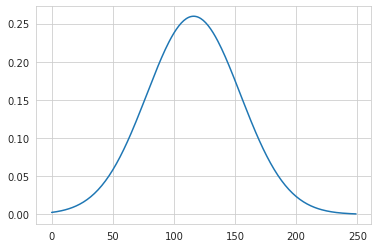

In [397]:
plt.plot(py_xt[:,100])

In [398]:
"""Analytical p(y|x,t)"""
muz_xt = ((x*c_x/(s_x**2)).sum() + t[None,:]*c_t/(s_t**2)) / (((c_x**2/(s_x**2)).sum() + c_t**2/(s_t**2) + 1))
sz_xt = 1/(np.sqrt((c_x**2/(s_x**2)).sum() + c_t**2/(s_t**2) + 1))
C1 = (c_yz**2)/(s_y**2) + 1/(sz_xt**2)
A = (-(4*c_yz**2)/(s_y**4)/(4*C1) + 1/(s_y**2))
B = -(2*c_yt*t[None,:]/(s_y**2) + (4*c_yz/(s_y**2))*(2*muz_xt/(sz_xt**2) - 2*c_yt*c_yz*t[None,:]/(s_y**2))/(4*C1))
analytic_py_xt = scipy.stats.norm.pdf(y[:,None], loc=-B/(2*A), scale=1/np.sqrt(A))

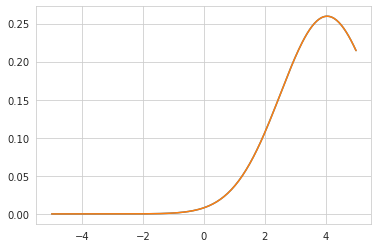

In [399]:
plt.plot(y,analytic_py_xt[:,200])
plt.plot(y,py_xt[:,200])

In [400]:
"""Testing P(z|x,t)"""
pz_xt = scipy.stats.norm.pdf(x0, loc=c_x[0]*z[:,None], scale=s_x[0]) \
        *scipy.stats.norm.pdf(x1, loc=c_x[1]*z[:,None], scale=s_x[1]) \
        *scipy.stats.norm.pdf(z[:,None]) \
        *scipy.stats.norm.pdf(t[None,:], loc=c_t*z[:,None], scale=s_t)
pz_xt = pz_xt / (pz_xt.sum(0)*dz)#Normalization, the calculation here bayes rule

analytic_pz_xt = scipy.stats.norm.pdf(z[:,None], muz_xt, sz_xt)

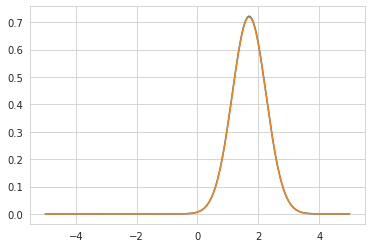

In [401]:
plt.plot(z, pz_xt[:,200])
plt.plot(z, analytic_pz_xt[:,200])

In [417]:
muz_ct = (c_t/(s_t**2)) / (((c_x**2/(s_x**2)).sum() + c_t**2/(s_t**2) + 1))
sz_xt = 1/(np.sqrt((c_x**2/(s_x**2)).sum() + c_t**2/(s_t**2) + 1))
C1 = (c_yz**2)/(s_y**2) + 1/(sz_xt**2)
A = (-(4*c_yz**2)/(s_y**4)/(4*C1) + 1/(s_y**2))
Bt = (-(2*c_yt/(s_y**2) + (4*c_yz/(s_y**2))*(2*muz_ct/(sz_xt**2) - 2*c_yt*c_yz/(s_y**2))/(4*C1)))
-Bt/(2*A)

array([1.09230769])

In [424]:
"""The optimal regression coefficient of t"""
ct_theory = -1/(2*A)*(\
            -2*c_yt/(s_y**2) + 2*c_yt*c_yz**2/(s_y**4*C1) \
            -2*c_yz/(s_y**2*sz_xt**2*C1) * (c_t/(s_t**2*((c_x**2/(s_x**2)).sum() + c_t**2/(s_t**2) + 1))))

In [425]:
((-B/(2*A))[0][-1] - (-B/(2*A))[0][0])/(t[-1]-t[0])

1.0923076923076924

In [426]:
ct_theory

array([1.09230769])

In [430]:
"""define all kinds of other things"""
datasize_times = 10
num_epochs = 100
lr_start = 0.1
lr_end = 0.01
input_dim = 2
z_dim = 1
binary_t_y = False
p_y_zt_nn = False
q_z_xty_nn = False
device = "cpu"

In [431]:
"""Let's define the model here"""
c_t = np.array([0.5])
s_t = np.array([1])
c_yz = np.array([0.6])
c_yt = np.array([1])
s_y = np.array([1.5])

In [460]:
num_samples = 10000
BATCH_SIZE = 1000

In [433]:
from sklearn.linear_model import LinearRegression

In [437]:
"""tavoite: käydä läpi eri x-pituuksia ja katsoa, minkälainen tulos saadaan lineaarisesta regressiosta
suoraan x ja t vs VAE:n t->y structural parametri"""
models_VAE = {}
folder = "linear_proxynumber_testing_data"
name = "linear_proxynumber_testing"


x_lens = list(range(2,10))
for i in range(len(x_lens)):
    x_len = x_lens[i]
    c_x = np.array(x_len*[1])
    s_x = np.array(x_len*[1])
    
    models_VAE[i] = {}
    models_reg[i] = {}
    
    for j in range(datasize_times):
        df = linear_data_df(num_samples, c_x, c_t, c_yz, c_yt, s_x, s_t, s_y)
        dataset = LinearDataset(df)
        dataloader = LinearDataLoader(dataset, validation_split=0.0)
        train_loader, test_loader = dataloader.get_loaders(batch_size=BATCH_SIZE)
        #dummy test loader
        test_loader, _ = LinearDataLoader(LinearDataset(df[:1]), validation_split=0.0).get_loaders(batch_size=1)

        model = run_cevae(num_epochs, lr_start, lr_end, train_loader, test_loader, input_dim=x_len, z_dim=1,
                  device='cpu', plot_curves=False, print_logs=False, binary_t_y=False, 
                  p_y_zt_nn=False, q_z_xty_nn=False)
        models_VAE[i][j] = model
        
        torch.save(model.state_dict(), "./data/{}/model_{}_{}_{}".format(folder,name,x_len,j))
        df.to_pickle("./data/{}/data_{}_{}_{}".format(folder,name,x_len,j))
        
        print("Len {}, run {} done".format(x_len, j))

Len 2, run 0 done
Len 2, run 1 done
Len 2, run 2 done
Len 2, run 3 done
Len 2, run 4 done
Len 2, run 5 done
Len 2, run 6 done
Len 2, run 7 done
Len 2, run 8 done
Len 2, run 9 done
Len 3, run 0 done
Len 3, run 1 done
Len 3, run 2 done
Len 3, run 3 done
Len 3, run 4 done
Len 3, run 5 done
Len 3, run 6 done
Len 3, run 7 done
Len 3, run 8 done
Len 3, run 9 done
Len 4, run 0 done
Len 4, run 1 done
Len 4, run 2 done
Len 4, run 3 done
Len 4, run 4 done
Len 4, run 5 done
Len 4, run 6 done
Len 4, run 7 done
Len 4, run 8 done
Len 4, run 9 done
Len 5, run 0 done
Len 5, run 1 done
Len 5, run 2 done
Len 5, run 3 done
Len 5, run 4 done
Len 5, run 5 done
Len 5, run 6 done
Len 5, run 7 done
Len 5, run 8 done
Len 5, run 9 done
Len 6, run 0 done
Len 6, run 1 done
Len 6, run 2 done
Len 6, run 3 done
Len 6, run 4 done
Len 6, run 5 done
Len 6, run 6 done
Len 6, run 7 done
Len 6, run 8 done
Len 6, run 9 done
Len 7, run 0 done
Len 7, run 1 done
Len 7, run 2 done
Len 7, run 3 done
Len 7, run 4 done
Len 7, run

In [461]:


models_reg = {}
theory_t_coef = []
x_lens = list(range(2,10))
for i in range(len(x_lens)):
    x_len = x_lens[i]
    c_x = np.array(x_len*[1])
    s_x = np.array(x_len*[1])
    models_reg[i] = {}
    for j in range(datasize_times):
        df = linear_data_df(num_samples, c_x, c_t, c_yz, c_yt, s_x, s_t, s_y)
        model_reg = LinearRegression(fit_intercept=False).fit(X=df.iloc[:,1:1+x_len+1],y=df['y'])
        models_reg[i][j] = model_reg
        
    ct_theory = c_yt + (c_t*c_yz)/(((c_x**2/(s_x**2)).sum() + c_t**2/(s_t**2) + 1)*s_t**2)
    theory_t_coef.append(ct_theory)

In [463]:
#Load the results in to convenient numpy arrays
model_cts = np.zeros((len(x_lens), datasize_times))
reg_cts = np.zeros((len(x_lens), datasize_times))
for i in range(len(x_lens)):
    for j in range(datasize_times):
        model_cts[i,j] = models_VAE[i][j].decoder.y_nn.weight[0,1].detach().numpy()
        reg_cts[i,j] = models_reg[i][j].coef_[-1]

In [394]:
models_reg[0].coef_

array([0.18891078, 0.17915098, 1.12001573])

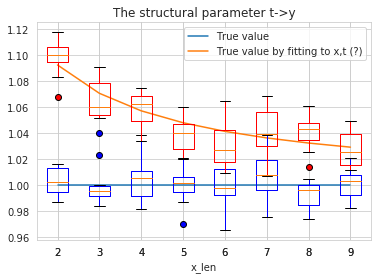

In [481]:
"""Plot results"""
plt.figure()
plt.plot([x_lens[0], x_lens[-1]], 2*[c_yt])
plt.title("The structural parameter t->y")
plt.xlabel("x_len")
plt.plot(x_lens, theory_t_coef, '-')
plt.legend(["True value", "True value by fitting to x,t (?)"])

plt.boxplot(model_cts.T, positions=x_lens, boxprops={"color":"b"}, whiskerprops={"color":"b"},
           flierprops={"markerfacecolor":"b"})
plt.boxplot(reg_cts.T, positions=x_lens, boxprops={"color":"r"}, whiskerprops={"color":"r"},
           flierprops={"markerfacecolor":"r"})
plt.show()